In [ ]:
# Use the environment variable if the user doesn't provide Project ID.
import os

import vertexai
from vertexai.preview.generative_models import (
    FunctionDeclaration,
    GenerativeModel,
    Tool,
    ToolConfig,
    Part,
    GenerationConfig,
)
PROJECT_ID = "104916006626"  # @param {type: "string", placeholder: "[your-project-id]" isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "xyz":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "australia-southeast1")

vertexai.init(project="104916006626", location=LOCATION)

In [ ]:
import os
from google.oauth2 import service_account

# Path to your service account key file
key_path = "C:\\Users\\shres\\Projects\\RAG-case-study\keys\\keyproject-401005-6e1cdcbb5996.json"

# Create credentials using the service account key file
credentials = service_account.Credentials.from_service_account_file(
    key_path
)

# Set the credentials for the current environment
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_path
# auth_request = transport.requests.Request()
# credentials.refresh(auth_request)

In [ ]:
# Controlled generation example test
response_schema = {
    "type": "array",
    "items": {
        "type": "object",
        "properties": {
            "recipe_name": {
                "type": "string",
            },
        },
        "required": ["recipe_name"],
    },
}

model = GenerativeModel("gemini-1.5-pro-002")

response = model.generate_content(
    "List a few popular cookie recipes",
    generation_config=GenerationConfig(
        response_mime_type="application/json", response_schema=response_schema
    ),
)

print(response.text)

## Document preprocessing:

Each document is to pre-processed individually as the structure of each document is different from the other. The objective it to extract meaningful chunks out of each document while preserving the original structure of the document, long term and short term context so that the chunk is indexed better and retrieved accurately.
The chunking strategy is as follows:
- LLM to create an index for the document dividing the document into various sections based on heading and sub headings. This will be used as metadata for the chunk.
- The document generates chunks by outputing the first and last sentence for the chunk. The chunk is then extracted from the md file which contains the document text. Generated chunk is restricted insize to a set number of tokens
- Each chunk is appended with short term and long term context for the document to aid the embedding and retrieval process.
- LLM must help remove unnecessary headers and footers  of the document


In [9]:
import logging
import time
from pathlib import Path
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem
from docling.datamodel.base_models import FigureElement, InputFormat, Table
from docling.datamodel.pipeline_options import (
    AcceleratorDevice,
    AcceleratorOptions,
    PdfPipelineOptions,
    TesseractCliOcrOptions,
    TesseractOcrOptions,
)
from docling.document_converter import DocumentConverter, PdfFormatOption

_log = logging.getLogger(__name__)

In [4]:
IMAGE_RESOLUTION_SCALE = 2.0

In [1]:
from pathlib import Path
import logging
from typing import Dict, List
from transformers import AutoTokenizer
from docling.chunking import HybridChunker
from docling.document_converter import DocumentConverter

class DocumentChunker:
    def __init__(self, base_dir: str = "processed_docs", model_id: str = "answerdotai/ModernBERT-base"):
        """
        Initialize the DocumentChunker with necessary components.
        
        Args:
            base_dir: Base directory containing markdown files
            model_id: Model ID for the tokenizer
        """
        # Setup logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)
        
        self.base_dir = Path(base_dir)
        self.model_id = model_id
        
        # Initialize components
        self._setup_components()
        
        # Store results
        self.document_chunks: Dict[str, List[str]] = {}

    def _setup_components(self) -> None:
        """Initialize tokenizer, chunker and document converter."""
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_id)
        self.chunker = HybridChunker(
            tokenizer=self.tokenizer,
            merge_peers=True,
        )
        self.doc_converter = DocumentConverter()
        
    def process_single_document(self, file_path: Path) -> List[str]:
        """
        Process a single markdown file and return its chunks.
        
        Args:
            file_path: Path to the markdown file
            
        Returns:
            List of chunks for the document
        """
        chunks = []
        
        try:
            # Convert markdown to docling document
            doc = self.doc_converter.convert(source=str(file_path)).document
            
            # Generate and store chunks in order
            for chunk in self.chunker.chunk(dl_doc=doc):
                chunks.append(self.chunker.serialize(chunk=chunk))
                
            self.logger.info(f"Successfully processed {file_path.name} - Generated {len(chunks)} chunks")
            
        except Exception as e:
            self.logger.error(f"Error processing {file_path.name}: {str(e)}")
        
        return chunks

    def process_directory(self) -> Dict[str, List[str]]:
        """
        Process all markdown files in the directory and its subdirectories.
        
        Returns:
            Dictionary mapping document names to their ordered chunks
        """
        # Find all markdown files
        md_files = list(self.base_dir.glob("**/*-with-image-refs.md"))
        
        if not md_files:
            self.logger.warning(f"No markdown files found in {self.base_dir}")
            return self.document_chunks
        
        self.logger.info(f"Found {len(md_files)} markdown files to process")
        
        # Process each file
        for md_file in md_files:
            self.logger.info(f"Processing {md_file.relative_to(self.base_dir)}")
            
            # Store chunks with document name as key
            doc_key = md_file.stem
            self.document_chunks[doc_key] = self.process_single_document(md_file)
        
        self.logger.info(f"Completed processing all documents")
        return self.document_chunks
    
    def get_document_statistics(self) -> None:
        """Print statistics about processed documents and their chunks."""
        if not self.document_chunks:
            print("No documents have been processed yet.")
            return
            
        print("\nDocument Processing Statistics:")
        print("-" * 30)
        for doc_name, chunks in self.document_chunks.items():
            print(f"\nDocument: {doc_name}")
            print(f"Number of chunks: {len(chunks)}")
            if chunks:
                avg_chunk_length = sum(len(self.tokenizer.tokenize(chunk)) 
                                     for chunk in chunks) / len(chunks)
                print(f"Average chunk length: {avg_chunk_length:.2f} tokens")



c:\Users\shres\anaconda3\envs\rag_case_study\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Example usage
if __name__ == "__main__":
    # Initialize the chunker
    doc_chunker = DocumentChunker()
    
    # Process all documents
    document_chunks = doc_chunker.process_directory()
    
    # Print statistics
    doc_chunker.get_document_statistics()
    
    # Access chunks for a specific document
    # doc_name = next(iter(document_chunks))
    # print(f"\nFirst chunk of {doc_name}:")
    # print(document_chunks[doc_name][0][:500])

INFO:__main__:Found 3 markdown files to process
INFO:__main__:Processing AI_ACT\AI_ACT-with-image-refs.md
INFO:docling.document_converter:Going to convert document batch...
INFO:docling.pipeline.base_pipeline:Processing document AI_ACT-with-image-refs.md
INFO:docling.document_converter:Finished converting document AI_ACT-with-image-refs.md in 181.56 sec.
Token indices sequence length is longer than the specified maximum sequence length for this model (8230 > 8192). Running this sequence through the model will result in indexing errors
INFO:__main__:Successfully processed AI_ACT-with-image-refs.md - Generated 152 chunks
INFO:__main__:Processing Cybersecurity_California_Privacy\Cybersecurity_California_Privacy-with-image-refs.md
INFO:docling.document_converter:Going to convert document batch...
INFO:docling.pipeline.base_pipeline:Processing document Cybersecurity_California_Privacy-with-image-refs.md
INFO:docling.document_converter:Finished converting document Cybersecurity_California_Pr


Document Processing Statistics:
------------------------------

Document: AI_ACT-with-image-refs
Number of chunks: 152
Average chunk length: 1133.82 tokens

Document: Cybersecurity_California_Privacy-with-image-refs
Number of chunks: 41
Average chunk length: 266.54 tokens

Document: GDPR-with-image-refs
Number of chunks: 122
Average chunk length: 938.01 tokens


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Dict, List, Tuple

def analyze_chunk_distribution(document_chunks: Dict[str, List[str]], tokenizer) -> Tuple[Dict[str, List[int]], Dict[str, Dict[str, float]]]:
    """
    Analyze and visualize chunk length distributions across all documents.
    
    Args:
        document_chunks: Dictionary mapping document names to their chunks
        tokenizer: Tokenizer instance to calculate token lengths
    
    Returns:
        Tuple containing:
        - Dictionary mapping document names to their chunk lengths
        - Dictionary containing statistics for each document
    """
    if not document_chunks:
        print("No documents to analyze.")
        return {}, {}
    
    # Calculate chunk lengths and statistics for each document
    doc_chunk_lengths = {}
    doc_statistics = {}
    
    for doc_name, chunks in document_chunks.items():
        # Get token lengths for each chunk
        chunk_lengths = [len(tokenizer.tokenize(chunk)) for chunk in chunks]
        doc_chunk_lengths[doc_name] = chunk_lengths
        
        # Calculate statistics
        doc_statistics[doc_name] = {
            'total_chunks': len(chunk_lengths),
            'mean_length': np.mean(chunk_lengths),
            'median_length': np.median(chunk_lengths),
            'min_length': np.min(chunk_lengths),
            'max_length': np.max(chunk_lengths),
            'std_dev': np.std(chunk_lengths)
        }
    
    # Create visualizations
    _plot_chunk_distributions(doc_chunk_lengths, doc_statistics)
    _print_summary_statistics(doc_chunk_lengths)
    
    return doc_chunk_lengths, doc_statistics

def _plot_chunk_distributions(doc_chunk_lengths: Dict[str, List[int]], 
                            doc_statistics: Dict[str, Dict[str, float]]) -> None:
    """
    Create visualizations for chunk length distributions.
    
    Args:
        doc_chunk_lengths: Dictionary mapping document names to chunk lengths
        doc_statistics: Dictionary containing statistics for each document
    """
    num_docs = len(doc_chunk_lengths)
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(15, 5 * num_docs))
    
    # Plot for each document
    for idx, (doc_name, chunk_lengths) in enumerate(doc_chunk_lengths.items(), 1):
        stats = doc_statistics[doc_name]
        
        # Histogram
        plt.subplot(num_docs, 2, 2*idx - 1)
        sns.histplot(chunk_lengths, bins=30)
        plt.axvline(stats['mean_length'], color='r', linestyle='--', label='Mean')
        plt.axvline(stats['median_length'], color='g', linestyle='--', label='Median')
        plt.title(f'Chunk Length Distribution - {doc_name}')
        plt.xlabel('Number of Tokens')
        plt.ylabel('Frequency')
        plt.legend()
        
        # Box plot
        plt.subplot(num_docs, 2, 2*idx)
        sns.boxplot(y=chunk_lengths)
        plt.title(f'Box Plot - {doc_name}')
        plt.ylabel('Number of Tokens')
        
        # Add statistics text
        stats_text = (
            f"Total chunks: {stats['total_chunks']}\n"
            f"Mean: {stats['mean_length']:.1f}\n"
            f"Median: {stats['median_length']:.1f}\n"
            f"Min: {stats['min_length']}\n"
            f"Max: {stats['max_length']}\n"
            f"Std Dev: {stats['std_dev']:.1f}"
        )
        plt.text(1.5, stats['median_length'], stats_text, 
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def _print_summary_statistics(doc_chunk_lengths: Dict[str, List[int]]) -> None:
    """
    Print comprehensive summary statistics for all documents.
    
    Args:
        doc_chunk_lengths: Dictionary mapping document names to chunk lengths
    """
    print("\nDocument Processing Summary:")
    print("-" * 50)
    
    all_lengths = []
    for doc_name, chunk_lengths in doc_chunk_lengths.items():
        all_lengths.extend(chunk_lengths)
        
        print(f"\n{doc_name}:")
        print(f"  Number of chunks: {len(chunk_lengths)}")
        print(f"  Average chunk length: {np.mean(chunk_lengths):.1f} tokens")
        print(f"  Median chunk length: {np.median(chunk_lengths):.1f} tokens")
        print(f"  Min chunk length: {min(chunk_lengths)} tokens")
        print(f"  Max chunk length: {max(chunk_lengths)} tokens")
    
    print("\nOverall Statistics:")
    print(f"Total number of chunks: {len(all_lengths)}")
    print(f"Average chunk length: {np.mean(all_lengths):.1f} tokens")
    print(f"Median chunk length: {np.median(all_lengths):.1f} tokens")
    print(f"Standard deviation: {np.std(all_lengths):.1f} tokens")

# # Example usage
# if __name__ == "__main__":
#     # Assuming you have a DocumentChunker instance with processed documents
#     doc_chunker = DocumentChunker()
#     document_chunks = doc_chunker.process_directory()
    


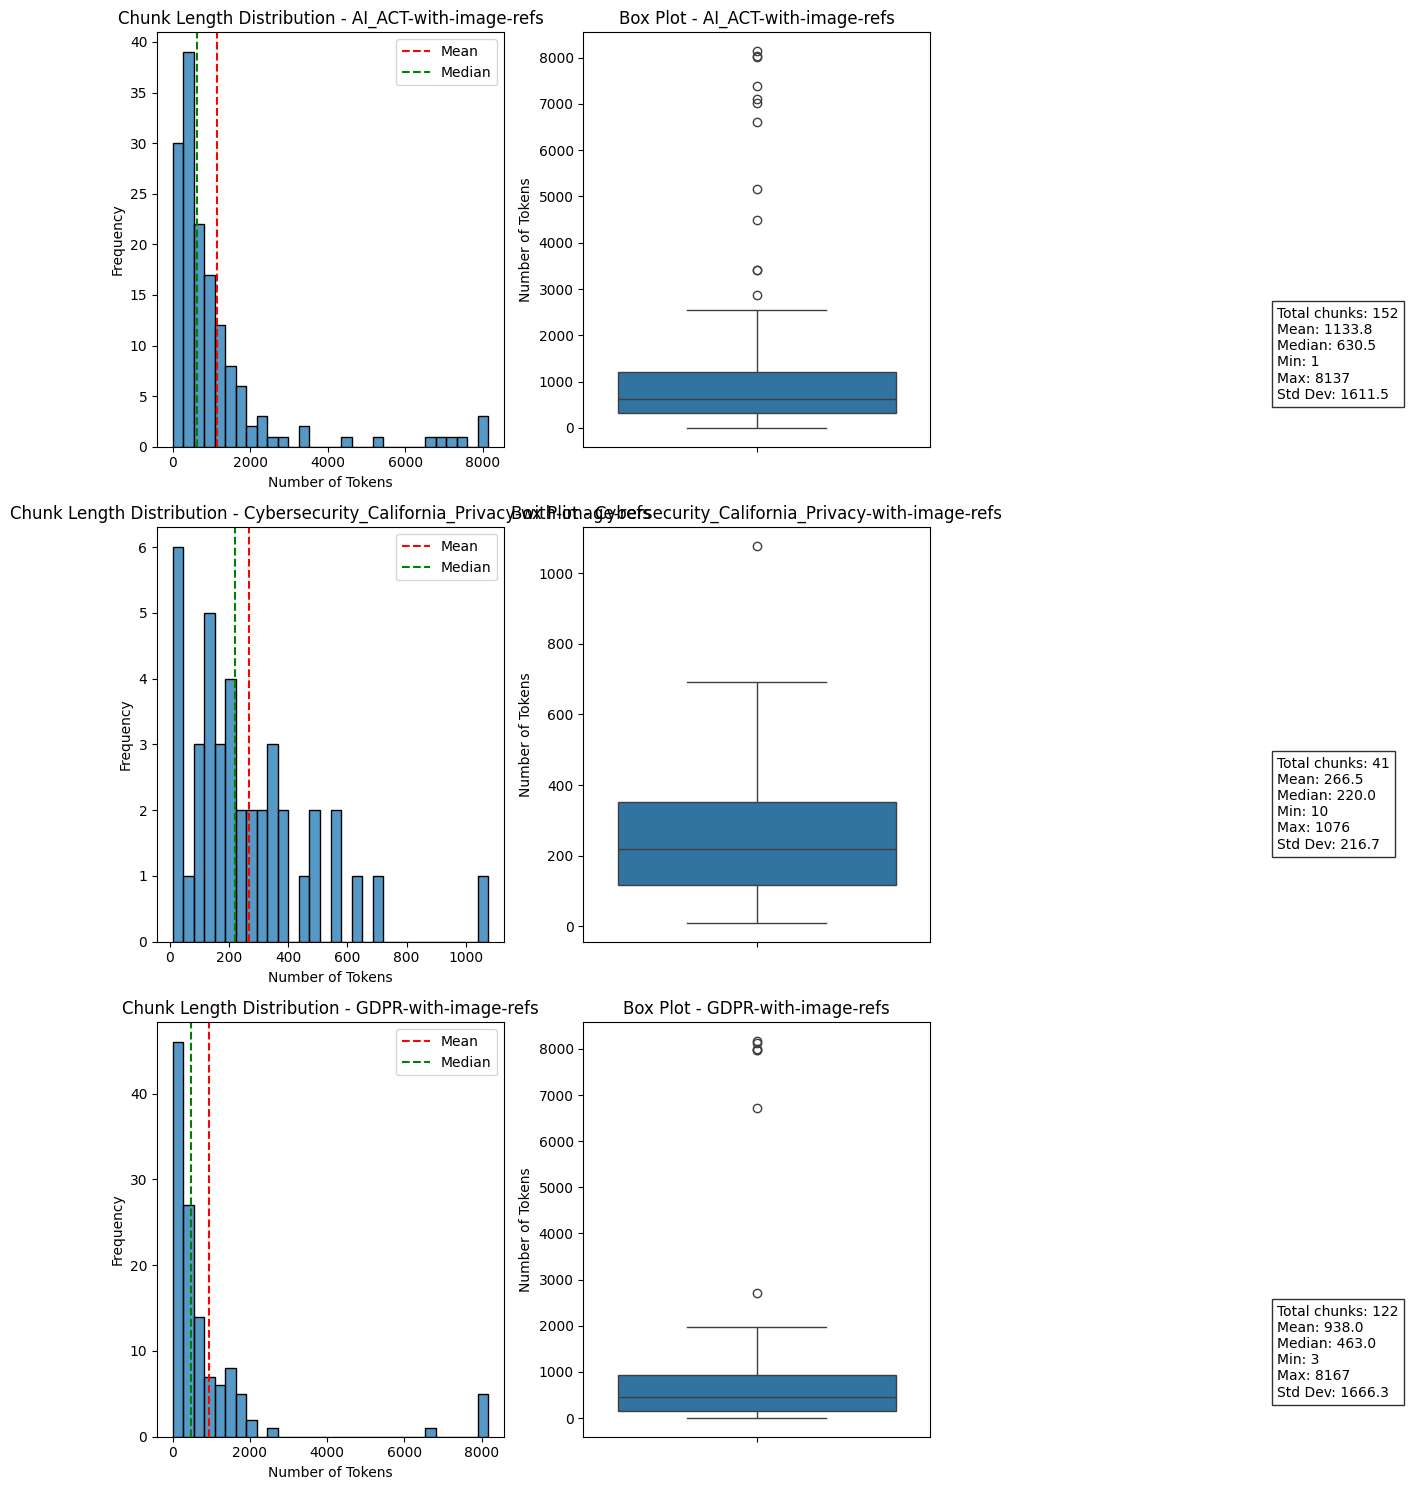


Document Processing Summary:
--------------------------------------------------

AI_ACT-with-image-refs:
  Number of chunks: 152
  Average chunk length: 1133.8 tokens
  Median chunk length: 630.5 tokens
  Min chunk length: 1 tokens
  Max chunk length: 8137 tokens

Cybersecurity_California_Privacy-with-image-refs:
  Number of chunks: 41
  Average chunk length: 266.5 tokens
  Median chunk length: 220.0 tokens
  Min chunk length: 10 tokens
  Max chunk length: 1076 tokens

GDPR-with-image-refs:
  Number of chunks: 122
  Average chunk length: 938.0 tokens
  Median chunk length: 463.0 tokens
  Min chunk length: 3 tokens
  Max chunk length: 8167 tokens

Overall Statistics:
Total number of chunks: 315
Average chunk length: 945.1 tokens
Median chunk length: 479.0 tokens
Standard deviation: 1553.0 tokens


In [5]:
# Generate visualizations and get statistics
chunk_lengths, statistics = analyze_chunk_distribution(
    document_chunks=document_chunks,
    tokenizer=doc_chunker.tokenizer
)

### Analysis:
1. Basic chunker used based on the hierarchical hybrid chunker for markdownfiles
2. Tokenizer used has a maximum context length of 8192 tokens. From the statistics of the chunks it can be observed that the average chunk size is less than 1000.
3. Chunks are not optimised for retieval: No chunk overlap, short term context, long term context, metadata.
4. Multimodal features and embedding not possible
5. Since chunk size much smaller compared to the maximum context length of the tokenizer there is scope for increase in chunk length to optimise it for retrieval

### Future work:
1. Enrich chunk content as to make retrieval accurate and efficient (fit to context length)
2. Cross document chunking to retrieve info for queries that could refer to multiple documents
3. Aggregated info chunks to
4. Chunking with grounding. Short term context in each chunk must have references to the chunks it refers to. Same with long term context


### Indexing 
With the baseline set of chunks, we can now move to indexing strategies. There are a few stragies that can be used for indexing and retrieval:
1. Basic cosine similarity for retrieval: Very fast and easy to understand as doc embeddings are retrieved using vallina cosine similarity (dot product of embedding pairs).
2. BERT similarity cross encoder: Very slow but highly accurate as dense embeddings of document-text pairs are calculated. Not very scalable since the time complexity for retrieval will exponentially increase
3. ColBERT based late interaction: Matches accuracy of BERT based methods without sacrificing on speed of retrieval due to late interaction of embeddings. Dense embeddings are used for better representation and doc embeddings are calculated offline for fater retrieval
4. Vanilla cosine similarity + ColBERT reranker: Here the small set of documents identified by cosine similarity are reranked using the reranker which tends to be more accurate
5. ColBERT + BM25: Since we are using data in the domain of regulation and compoliance, word matching based retrieval could be quite useful in cases where users are looking for relevant documents for a law, sub-section etc